In [95]:
import pandas
import numpy

In [96]:
# Read the data
df = pandas.read_csv('sales_data.csv')
df.head()

,sales,date
0,112,2022-08-21
1,118,2022-08-22
2,132,2022-08-23
3,129,2022-08-24
4,121,2022-08-25


In [97]:
# date to datetime object
df['date'] = pandas.to_datetime(df['date'])

# date to index
df.set_index('date', inplace=True)

In [98]:
# general info about the data
df.info()

# check if there are any missing values
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 2022-08-21 to 2023-01-11
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   sales   144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB


sales    0
dtype: int64

<AxesSubplot:xlabel='date'>

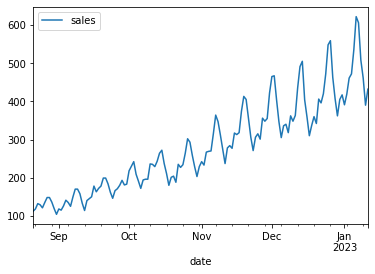

In [99]:
# plot the sales in a line chart
df.plot()

In [100]:
# create lagged features for sales for five days
def create_lagged_features(dataframe, lag=1):
    dataframe['t-'+str(lag)] = dataframe['sales'].shift(lag)
    return dataframe

for i in range(1,6):
    df = create_lagged_features(df, i)

# drop the first five rows
df.dropna(inplace=True)
df.head()

,sales,t-1,t-2,t-3,t-4,t-5
date,,,,,,
2022-08-26,135,121.0,129.0,132.0,118.0,112.0
2022-08-27,148,135.0,121.0,129.0,132.0,118.0
2022-08-28,148,148.0,135.0,121.0,129.0,132.0
2022-08-29,136,148.0,148.0,135.0,121.0,129.0
2022-08-30,119,136.0,148.0,148.0,135.0,121.0


In [101]:
# split the data into train and test with in-built function
from sklearn.model_selection import train_test_split

X = df.drop('sales', axis=1)
y = df['sales']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [102]:
# # split the data into train, test and dev set
# def split_data(dataframe):
#     train = dataframe[:int(0.7*(len(dataframe)))]
#     temp = dataframe[int(0.7*(len(dataframe))):]
#     test = temp[:int(0.5*(len(temp)))]
#     dev = temp[int(0.5*(len(temp))):]
#     return train, test, dev
# 
# train, test, dev = split_data(df)

In [103]:
# # plot the train, test and dev set
# train['sales'].plot()
# test['sales'].plot()
# dev['sales'].plot()
# 
# # the gaps are normal because the sales can vary a lot from day to day

In [104]:
# # split the data into x and y
# def split_x_y(dataframe):
#     x = dataframe.drop('sales', axis=1)
#     y = dataframe['sales']
#     return x, y
# 
# x_train, y_train = split_x_y(train)
# x_test, y_test = split_x_y(test)
# x_dev, y_dev = split_x_y(dev)

In [105]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error

# create the model
model = xgb.XGBRegressor()

# fit the model
model.fit(X_train, y_train)

# predict the sales
y_pred = model.predict(X_test)

# calculate the mean absolute error
mean_absolute_error(y_test, y_pred)

65.67018454415458

In [106]:
#XGBoost: 65.67

<AxesSubplot:xlabel='date'>

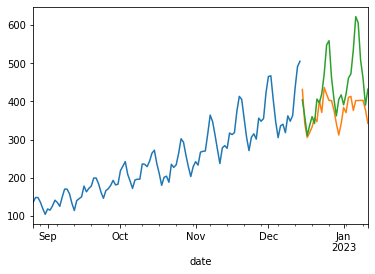

In [107]:
# plot the train set and y_pred and y_test
y_train.plot()
pandas.Series(y_pred, index=y_test.index).plot()
y_test.plot()


In [108]:
# linear regression
# import the model
from sklearn.linear_model import LinearRegression

# create the model
model = LinearRegression()

# fit the model
model.fit(X_train, y_train)

# predict the sales
y_pred = model.predict(X_test)

# calculate the mean absolute error
mean_absolute_error(y_test, y_pred)

41.035859620503935

<AxesSubplot:xlabel='date'>

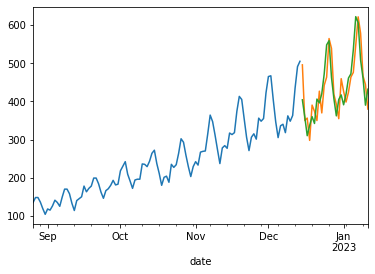

In [109]:
# plot the train set and y_pred and y_test
y_train.plot()
pandas.Series(y_pred, index=y_test.index).plot()
y_test.plot()

In [110]:
# Random Forest
# import the model
from sklearn.ensemble import RandomForestRegressor

# create the model
model = RandomForestRegressor()

# fit the model
model.fit(X_train, y_train)

# predict the sales
y_pred = model.predict(X_test)

# calculate the mean absolute error
mean_absolute_error(y_test, y_pred)

46.87142857142856

<AxesSubplot:xlabel='date'>

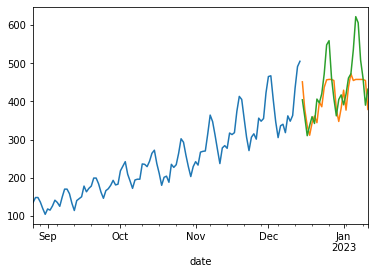

In [111]:
# plot the train set and y_pred and y_test
y_train.plot()
pandas.Series(y_pred, index=y_test.index).plot()
y_test.plot()

Next we are going to test ARIMA.

In [112]:
# Setup and Import data
from statsmodels.tsa.stattools import adfuller
import pandas as pd
import numpy as np
%matplotlib inline

# ADF Test
result = adfuller(df.sales, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'n_lags: {result[1]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')    

ADF Statistic: 0.7223387127445756
n_lags: 0.9902732941721091
p-value: 0.9902732941721091
Critial Values:
   1%, -3.4837793736959997
Critial Values:
   5%, -2.88495387648
Critial Values:
   10%, -2.579256976


A p-value greater than 0.05 and the ADF statistic is greater than the critical values,
suggests that the null hypothesis that the time series is non-stationary cannot be rejected. 
In other words, the data is non-stationary.

It will require differencing to make it stationary, at least a difference order of 1.

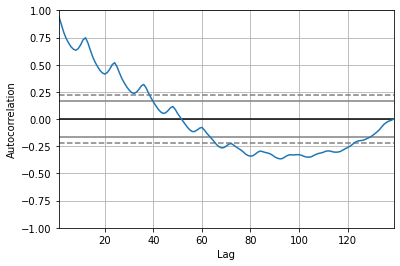

In [113]:
from matplotlib import pyplot
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df.sales)
pyplot.show()

The parameters p, d, and q in an ARIMA model refer to the order of the differencing, the order of the autoregression, and the order of the moving average, respectively. 

In [114]:
# ARIMA
# import the model
from statsmodels.tsa.arima.model import ARIMA

# create the model
model = ARIMA(df.sales, order=(40,1,10))

# fit the model
model_fit = model.fit()

# predict the sales
y_pred = model_fit.forecast(steps=len(y_test))[0]

/home/olli/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/olli/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/olli/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/olli/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/olli/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimi

In [115]:
# calculate the number of days ahead
days_ahead = len(y_test)

# create a date range for the next n days
date_rng = pandas.date_range(start=df.sales.index[-1], periods=days_ahead+1, freq='D')

# set the date range as the index for y_pred
y_pred = pandas.Series(y_pred[:,0], index=date_rng[1:])

# plot the train set and y_pred and y_test
df.sales.plot()
y_pred.plot()

IndexError: invalid index to scalar variable.

10:06:30 - cmdstanpy - INFO - Chain [1] start processing
10:06:30 - cmdstanpy - INFO - Chain [1] done processing


<AxesSubplot:xlabel='date'>

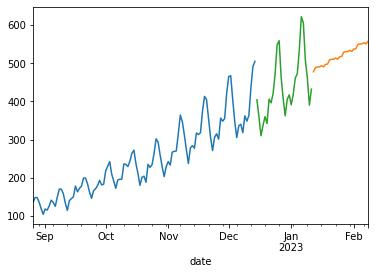

In [ ]:
# Prophet
# import the model
from prophet import Prophet

# create the model
model = Prophet()

# create the dataframe
df.reset_index(inplace=True)
df_prophet = df.rename(columns={'date': 'ds', 'sales': 'y'})

# fit the model
model.fit(df_prophet)

# create the future dataframe
future = model.make_future_dataframe(periods=len(y_test))

# predict the sales
forecast = model.predict(future)

# plot the train set and y_pred and y_test
y_train.plot()
forecast.set_index('ds').yhat[-len(y_test):].plot()
y_test.plot()

In [ ]:
# reshape the data for LSTM
X_train = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))

In [ ]:
# reshape the data for LSTM
X = X.values.reshape((X.shape[0], 1, X.shape[1]))

In [ ]:
# LSTM
# import the model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# create the model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# fit the model
model.fit(X, y, epochs=300, verbose=0)

# predict the sales
y_pred = model.predict(X, steps=(len(y_test)))

# calculate the number of days ahead
days_ahead = len(y_test)

# create a date range for the next n days
date_rng = pandas.date_range(start=y_test.index[-1], periods=days_ahead+1, freq='D')

# set the date range as the index for y_pred
y_pred = pandas.Series(y_pred[:,0], index=date_rng[1:])

# plot the train set and y_pred and y_test
y.plot()
y_pred.plot()

# # calculate the mean absolute error
# mean_absolute_error(y_test, y_pred[:,0])

28/28 [==============================] - 0s 1ms/step


ValueError: Length of values (139) does not match length of index (28)